数据加载

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
)
from imblearn.over_sampling import SMOTE
import shap

# Load dataset
data = pd.read_csv('/Users/rumic/Learn/Hypertension-risk-model-main.csv')

# Display basic information about the dataset
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   male           4240 non-null   int64  
 1   age            4240 non-null   int64  
 2   currentSmoker  4240 non-null   int64  
 3   cigsPerDay     4211 non-null   float64
 4   BPMeds         4187 non-null   float64
 5   diabetes       4240 non-null   int64  
 6   totChol        4190 non-null   float64
 7   sysBP          4240 non-null   float64
 8   diaBP          4240 non-null   float64
 9   BMI            4221 non-null   float64
 10  heartRate      4239 non-null   float64
 11  glucose        3852 non-null   float64
 12  Risk           4240 non-null   int64  
dtypes: float64(8), int64(5)
memory usage: 430.8 KB
None
              male          age  currentSmoker   cigsPerDay       BPMeds  \
count  4240.000000  4240.000000    4240.000000  4211.000000  4187.000000   
mean      0.429245    49

数据预处理

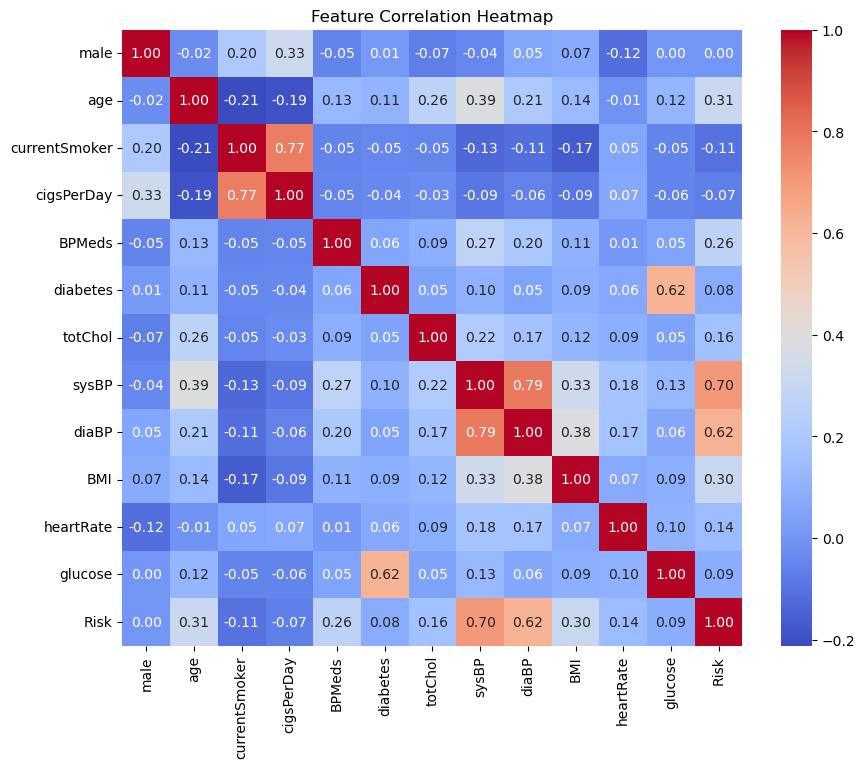

In [11]:
# 1. Handling missing values
data = data.dropna()  # Drop rows with missing values

# 2. Feature selection (retain 13 features)
features = ['male', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds',
            'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
target = 'Risk'

X = data[features]
y = data[target]

# 3. Feature correlation analysis
plt.figure(figsize=(10, 8))
sns.heatmap(data[features + [target]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# 4. Outlier detection and removal using IQR
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Filter data
X = X[~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)]
y = y[X.index]

# 5. Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

数据分割

In [24]:
# Splitting data (70:15:15)
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

基线模型：逻辑回归

Logistic Regression Metrics:
Accuracy: 0.8971
Precision: 0.9000
Recall: 0.8898
F1 Score: 0.8949


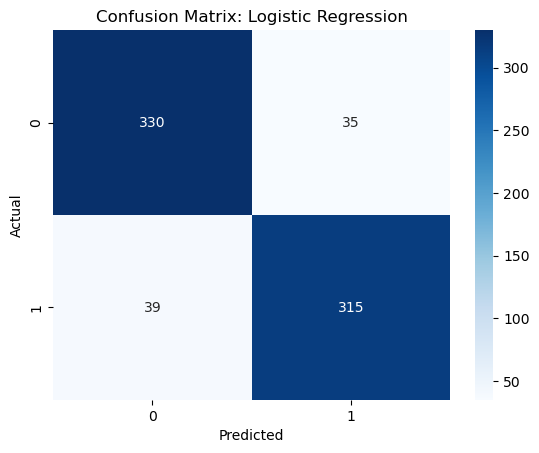

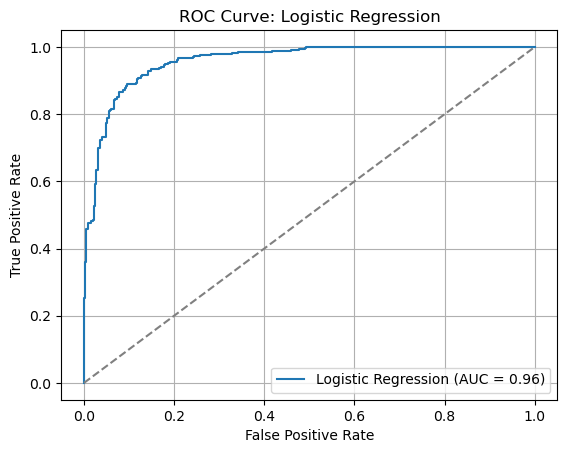

In [17]:
# Baseline model: Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# Metrics for Logistic Regression
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_log):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_log):.4f}")

# Confusion Matrix for Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve for Logistic Regression
fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title("ROC Curve: Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

MLP 模型及超参数调优

Best Parameters for MLP: {'alpha': 0.01, 'hidden_layer_sizes': (64, 64), 'learning_rate_init': 0.01}

Optimized MLP Classifier Metrics:
Accuracy: 0.9040
Precision: 0.8701
Recall: 0.9463
F1 Score: 0.9066


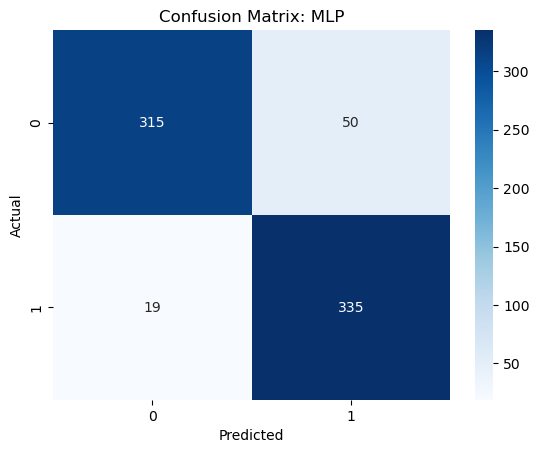

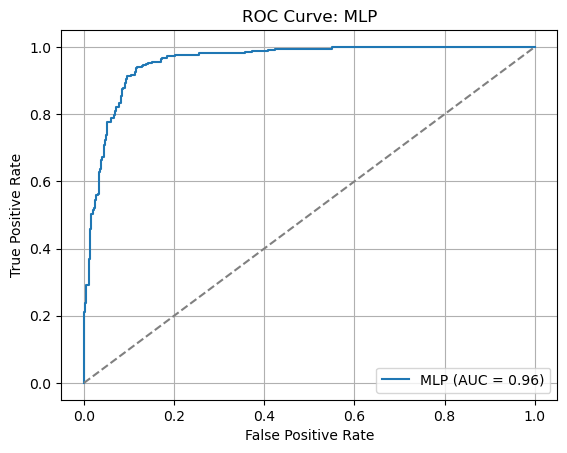

In [90]:
# MLP hyperparameter tuning with GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(64, 64), (128, 128), (64, 128)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
}
grid_mlp = GridSearchCV(
    MLPClassifier(max_iter=300, random_state=42, early_stopping=True, validation_fraction=0.15),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_mlp.fit(X_train, y_train)
print("Best Parameters for MLP:", grid_mlp.best_params_)

# Optimized MLP model
mlp = grid_mlp.best_estimator_
y_pred_mlp = mlp.predict(X_test)

# Evaluate metrics for MLP
print("\nOptimized MLP Classifier Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_mlp):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_mlp):.4f}")

# Confusion Matrix for MLP
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve for MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp.predict_proba(X_test)[:, 1])
roc_auc_mlp = roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title("ROC Curve: MLP")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

模型解释性分析

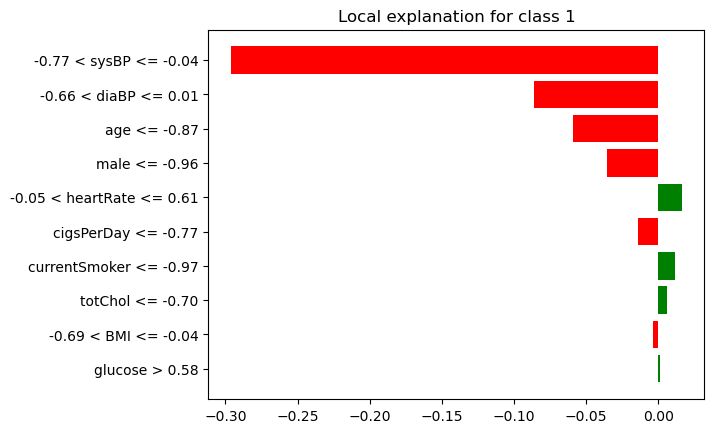

In [116]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME Explainer
explainer = LimeTabularExplainer(
    training_data=X_train_scaled, 
    feature_names=features, 
    class_names=['0', '1'],  # You can adjust class names based on your data
    discretize_continuous=True
)

# Select a sample from the test set to explain
sample_idx = 5  # For example, explain the 5th sample in the test set
sample_instance = X_test_scaled[sample_idx].reshape(1, -1)

# Explain the prediction for the sample instance
explanation = explainer.explain_instance(sample_instance[0], mlp.predict_proba)

# Show the explanation
explanation.show_in_notebook(show_table=True, show_all=False)

# Plot the explanation as a bar chart
explanation.as_pyplot_figure()
plt.show()